In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import cv2 as cv
from skimage.segmentation import slic

import findatree.io as io
import findatree.visualize as visual
import findatree.segmentation as segment
import findatree.segmentation2 as segment2

importlib.reload(segment)
importlib.reload(segment2)

plt.style.use(r"C:\Repos\findatree\own.mplstyle")

### Define raster-files and print infos

In [2]:
importlib.reload(io)
dir_names=[]
dir_names.extend([r'C:\Data\lwf\DSM_2021'])
dir_names.extend([r'C:\Data\lwf\DTM'])
dir_names.extend([r'C:\Data\lwf\Orthophotos_2021'])

file_names=[]
file_names.extend(['Tnr_12702_D-20210713_DSM.tif'])
file_names.extend(['tnr_12702_dtm.tif'])
file_names.extend(['Tnr_12702_2021_Ortho.tif'])


paths=[os.path.join(dir_names[i],file_name) for i, file_name in enumerate(file_names)]

io.print_raster_info(paths)


(0)
Name: C:/Data/lwf/DSM_2021/Tnr_12702_D-20210713_DSM.tif
Width[px]: 4749
Height[px]: 4626
No. of rasters: 1
  Index: 1, dtype: float32
Nodata values: (-32767.0,)

Coordinate reference system CRS: EPSG:25832
Geo bounds: BoundingBox(left=661774.3636313608, bottom=5470426.000381344, right=662196.9573473627, top=5470837.648840014)
Affine geo-transfrom: [0.08898583196501086, 0.0, 661774.3636313608, 0.0, -0.0889858319649575, 5470837.648840014]

(1)
Name: C:/Data/lwf/DTM/tnr_12702_dtm.tif
Width[px]: 398
Height[px]: 409
No. of rasters: 1
  Index: 1, dtype: float32
Nodata values: (-3.4028234663852886e+38,)

Coordinate reference system CRS: EPSG:25832
Geo bounds: BoundingBox(left=661789.9361519547, bottom=5470428.936913799, right=662187.9361519547, top=5470837.936913799)
Affine geo-transfrom: [1.0, 0.0, 661789.9361519547, 0.0, -1.0, 5470837.936913799]

(2)
Name: C:/Data/lwf/Orthophotos_2021/Tnr_12702_2021_Ortho.tif
Width[px]: 7913
Height[px]: 8617
No. of rasters: 5
  Index: 1, dtype: uint16


### Reproject raster-files to same area & resolution

In [3]:
importlib.reload(io)
res = 0.2
bands, mask, A, bound = io.reproject_all_intersect(paths, res=res)

C:\Users\flori\Anaconda3\envs\findatree_v01\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


### Define and normalize channels

In [4]:
importlib.reload(io)

cs_prim = {
    'dsm': bands[0][:,:,0],
    'dtm': bands[1][:,:,0],
    'blue': bands[2][:,:,0],
    'red': bands[2][:,:,1],
    'green': bands[2][:,:,2],
    're': bands[2][:,:,3],
    'nir': bands[2][:,:,4],
}

reduce = 1
cs = io.define_channels(cs_prim, reduce=reduce)

res_final = res * 2**reduce
print(f"Resolution of images: {res_final:.1f} m")

Resolution of images: 0.4 m


### Segmentation
#### (1) Global mask and local mask by adaptive gaussian thresholding

In [21]:
importlib.reload(segment2)

import skimage.filters as filters
import skimage.morphology as morph

# Rough global mask of positives
mask_global = (cs['chm'] > 3) & (cs['ndvi'] > 0.6)

# Local mask of positives by adaptive thresholding
img =cs['l'].copy()

distance = 20 / res_final
mask_local = segment2.local_thresholding(img, mask_global, distance)

Distance set to: 51 [px]


#### (2) Iterative shrinking of local mask and expansion of labels

In [22]:
importlib.reload(segment2)

# Iterative: Shrink mask & expand labels
thresh_dist = 10 / res_final
labels, bounds, mask_seed = segment2.shrinkmask_expandlabels_iter(
    mask_local,
    thresh_dist_start=thresh_dist,
    )

#### (3) Plot intermediate result

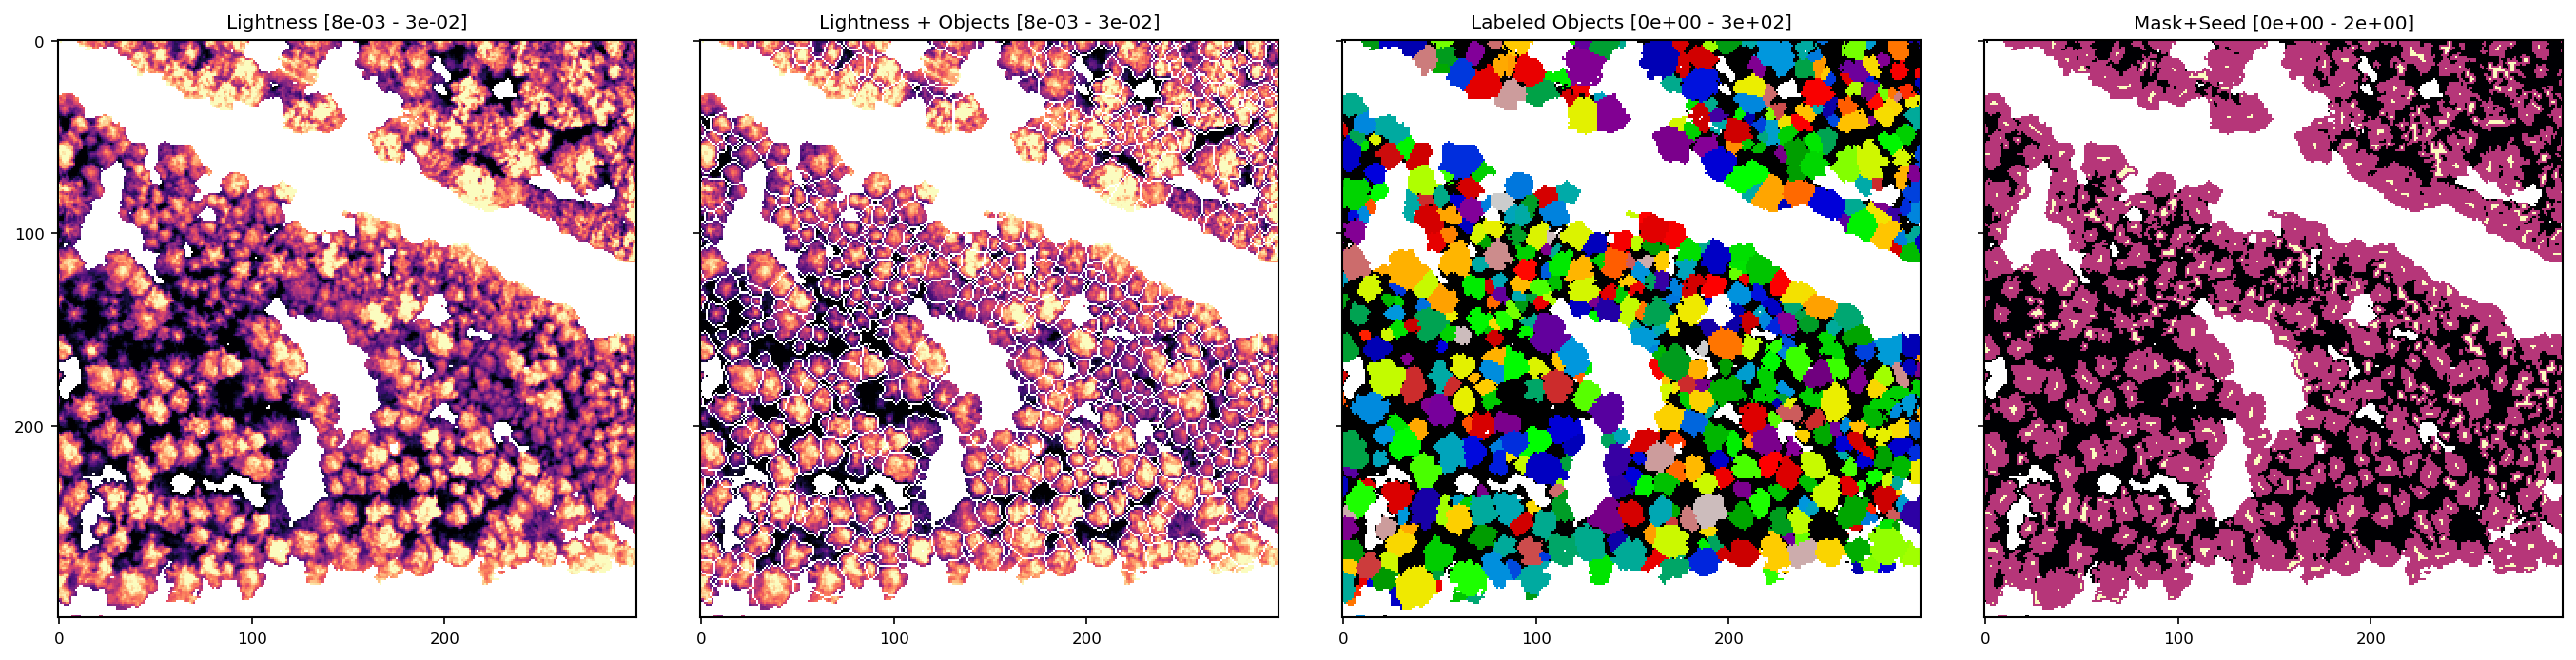

In [25]:
importlib.reload(visual)

segment_result = img.copy()
segment_result[bounds == 1] = np.nan

channels = [
    img, segment_result, labels, mask_seed, 
]
use_random_cmap = [False, False, True, False]
channels_names = ['Lightness', 'Lightness + Objects', 'Labeled Objects', 'Mask+Seed']
contrasts = [None, None, None, None]
xylim = [(500,150), (600,150)]

f, axs = visual.show_channels(
    channels,
    xylim=xylim,
    mask=mask_global,
    contrasts=contrasts,
    use_random_cmap=use_random_cmap,
    channel_names=channels_names,
    zoom=1.5,
    # n_cols_rows=(2,2),
)

# plt.savefig(r'C:\Users\flori\Desktop\plots\220325_tnr12702.pdf', transparent=True)